In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class BollingerBand():
    
    def __init__(self, symbol, SMA, dev, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.dev = dev
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
    def __repr__(self):
        rep = "BollingerBand(symbol = {}, SMA = {}, dev = {}, start = {}, end = {})"
        return rep.format(self.symbol, self.SMA, self.dev, self.start, self.end)
        
    def get_data(self):
        raw = pd.read_csv("Daily_nifty_data.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean()
        raw["Lower"] = raw["SMA"] - raw["price"].rolling(self.SMA).std() * self.dev
        raw["Upper"] = raw["SMA"] + raw["price"].rolling(self.SMA).std() * self.dev
        self.data = raw
        return raw
        
    def set_parameters(self, SMA = None, dev = None):
        ''' Updates parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean()
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data["SMA"] - self.data["price"].rolling(self.SMA).std() * self.dev
            self.data["Upper"] = self.data["SMA"] + self.data["price"].rolling(self.SMA).std() * self.dev
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["distance"] = data.price - data.SMA
        data["position"] = np.where(data.price < data.Lower, 1, np.nan)
        data["position"] = np.where(data.price > data.Upper, -1, data["position"])
        data["position"] = np.where(data.distance * data.distance.shift(1) < 0, 0, data["position"])
        data["position"] = data.position.ffill().fillna(0)
        data["strategy"] = data.position.shift(1) * data["returns"]
        data.dropna(inplace = True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
       
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1]
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | dev = {} | TC = {}".format(self.symbol, self.SMA, self.dev, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, boll):
        ''' Updates parameters and returns the negative absolute performance (for minimization algorithm).
        '''
        self.set_parameters(int(boll[0]), int(boll[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, dev_range):
        ''' Finds global maximum given the parameter ranges.
        '''
        opt = brute(self.update_and_run, (SMA_range, dev_range), finish=None)
        return opt, -self.update_and_run(opt)


In [3]:
tester = BollingerBand("Nifty50", 20, 2, "01-01-2008", "01-07-2021", 0.0004)

In [4]:
tester

BollingerBand(symbol = Nifty50, SMA = 20, dev = 2, start = 01-01-2008, end = 01-07-2021)

In [5]:
tester.test_strategy()

(0.365233, -2.315291)

In [6]:
tester.results.head(50)

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2008-01-29,5280.799805,0.001269,5797.337476,4813.806777,6780.868174,-516.537671,0.0,0.000000,0.0,1.001270,1.000000
2008-01-30,5167.600098,-0.021669,5746.747485,4742.101379,6751.393591,-579.147388,0.0,-0.000000,0.0,0.979807,1.000000
2008-01-31,5137.450195,-0.005851,5694.692505,4676.455011,6712.929998,-557.242310,0.0,-0.000000,0.0,0.974090,1.000000
2008-02-01,5317.250000,0.034399,5646.840015,4653.646646,6640.033384,-329.590015,0.0,0.000000,0.0,1.008181,1.000000
2008-02-04,5463.500000,0.027133,5606.060010,4656.139498,6555.980521,-142.560010,0.0,0.000000,0.0,1.035911,1.000000
2008-02-05,5483.899902,0.003727,5565.862500,4670.973360,6460.751640,-81.962598,0.0,0.000000,0.0,1.039779,1.000000
2008-02-06,5322.549805,-0.029864,5518.389990,4682.431752,6354.348228,-195.840186,0.0,-0.000000,0.0,1.009186,1.000000
2008-02-07,5133.250000,-0.036213,5467.204980,4671.479571,6262.930390,-333.954980,0.0,-0.000000,0.0,0.973294,1.000000
2008-02-08,5120.350098,-0.002516,5413.217480,4683.043751,6143.391210,-292.867383,0.0,-0.000000,0.0,0.970848,1.000000


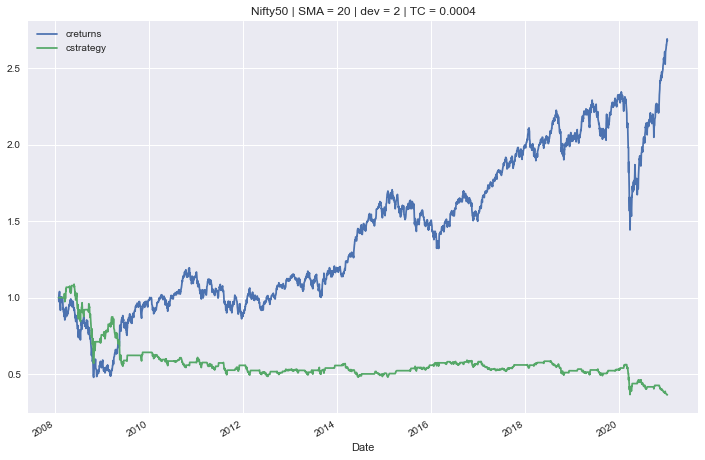

In [7]:
tester.plot_results()

In [8]:
tester.optimize_parameters((15, 100, 1), (1, 5, 1))

(array([19.,  3.]), 1.075394)

In [9]:
tester.test_strategy()

(1.075394, -1.550731)

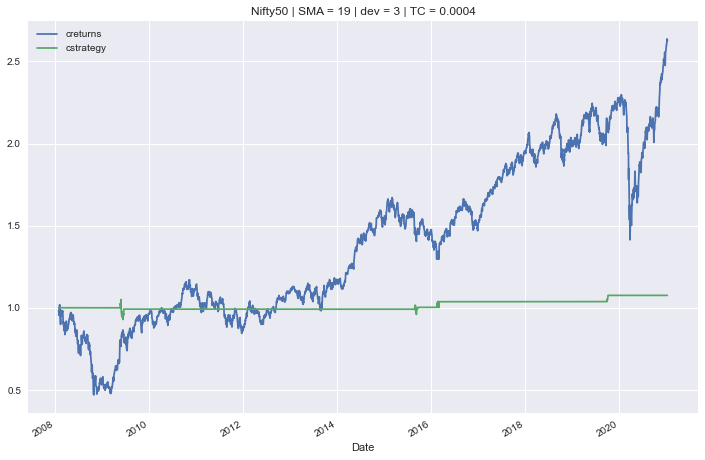

In [10]:
tester.plot_results()

In [11]:
tester.results

,price,returns,SMA,Lower,Upper,distance,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,,
2008-01-28,5274.100098,-0.020503,5824.523669,4355.854857,7293.192481,-550.423571,0.0,-0.0,0.0,0.979706,1.000000
2008-01-29,5280.799805,0.001269,5777.228927,4287.065245,7267.392609,-496.429122,0.0,0.0,0.0,0.980950,1.000000
2008-01-30,5167.600098,-0.021669,5724.021047,4207.779977,7240.262118,-556.420950,0.0,-0.0,0.0,0.959923,1.000000
2008-01-31,5137.450195,-0.005851,5664.186858,4152.365084,7176.008631,-526.736662,0.0,-0.0,0.0,0.954322,1.000000
2008-02-01,5317.250000,0.034399,5613.563168,4153.295275,7073.831061,-296.313168,0.0,0.0,0.0,0.987721,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-01-01,14018.500000,0.002625,13658.576275,12993.094090,14324.058459,359.923725,0.0,0.0,0.0,2.604048,1.075394
2021-01-04,14132.900391,0.008128,13699.478927,12996.903245,14402.054609,433.421464,0.0,0.0,0.0,2.625298,1.075394
2021-01-05,14199.500000,0.004701,13741.928917,12997.265114,14486.592719,457.571083,0.0,0.0,0.0,2.637670,1.075394
